In [56]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
import re
import time
import glob
import os
import random

import sys
from paths import Paths
paths = Paths()
sys.path.append(paths.scripts_root)
import util

import imutils

%load_ext autoreload
%autoreload 2

# Display entire width of browser
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

paths.print_paths()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Paths defined in paths module:
 paths.data_root: /Users/trafferty/data
 paths.notebook_root: /Users/trafferty/data/notebooks
 paths.scripts_root: /Users/trafferty/data/scripts
 paths.images_root: /Users/trafferty/data/images
 paths.projects_root: /Users/trafferty/data/projects
 paths.results_root: /Users/trafferty/data/results
 paths.tmp_root: /Users/trafferty/data/tmp
 paths.dat_root: /Users/trafferty/data/dat
 paths.tmp_dir: /Users/trafferty/tmp
 paths.ws_dir: /Users/trafferty/workspace
 paths.mii_home: /Users/trafferty/dev
 paths.inhouse: /Users/trafferty/dev/src/inhouse


In [57]:
local = True
if local:
    folder_root = f"{paths.tmp_dir}/ttm_marks/NZ2CDS3_20191108_IP_TTMD"
else:
    folder_root = "/Volumes/Data/NZ2CDS3/byDate/2019/11/08/B1/startTime_19_02_04_lot_232496_191108_MMO_Longevity_FF"

In [73]:
TTM_img_paths = glob.glob("%s/*.png" % (folder_root))
TTM_img_files = [os.path.basename(path) for path in TTM_img_paths ]

# B1-IP_TTMD-20191108_190526_138275+0900-w1-p1-s9-f5-1r1-2r141818-3r0.png
# suffix = 'B1-IP_TTMD'
# regex = r"%s-[0-9_+]*-w[1-9]-p1-s[0-9]-f5-.*png" % (suffix, f)
#LB_regex = r".*f5-.*png"

locs        = ["LB",  "LF",  "RF",  "RB" ]
search_strs = ['-f5-','-f6-','-f7-','-f8-']

file_paths = {}
for loc, search_str in zip(locs, search_strs):
    file_paths[loc] = [ x for x in TTM_img_paths if x.find(search_str)>-1 ]
    
for loc in locs:
    print(f"Found {len(file_paths[loc])} for location {loc}")
          
# LB_file_paths = [ x for x in TTM_img_paths if x.find('-f5-')>-1 ]
# LF_file_paths = [ x for x in TTM_img_paths if x.find('-f6-')>-1 ]
# RF_file_paths = [ x for x in TTM_img_paths if x.find('-f7-')>-1 ]
# RB_file_paths = [ x for x in TTM_img_paths if x.find('-f8-')>-1 ]

Found 1276 for location LB
Found 1276 for location LF
Found 1276 for location RF
Found 1276 for location RB


In [13]:
from skimage.segmentation import chan_vese

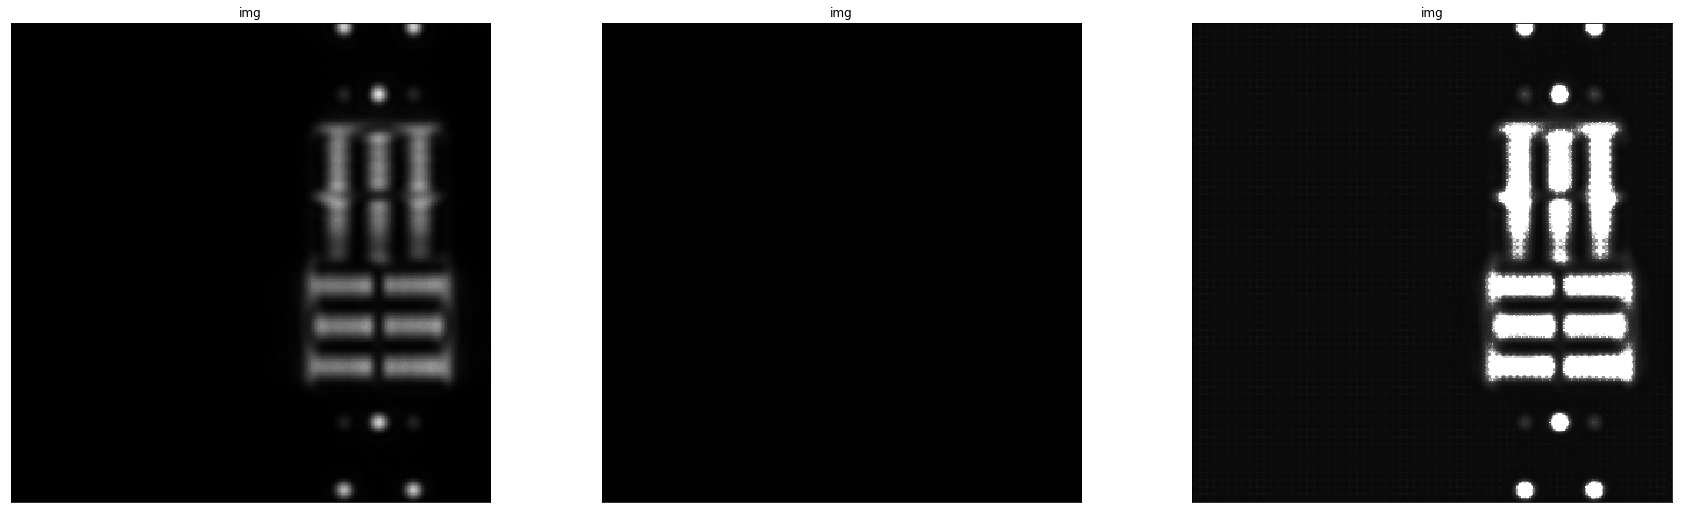

In [71]:
loc_str = "LB"
file_path = file_paths[loc_str][0]
img = cv2.imread(file_path, 0)
img.shape

#Feel free to play around with the parameters to see how they impact the result
cv = chan_vese(img, mu=0.25, lambda1=1, lambda2=20000, tol=1e-3, max_iter=200,
               dt=0.5, init_level_set="checkerboard", extended_output=True)

util.plot_imgs([(img,'img'),(cv[0],'img'),(cv[1],'img')], max_cols = 3)

In [59]:
def findAlignMatrix(unaligned_img, target_img, warp_mode, max_iters):
    # Define 2x3 or 3x3 matrices and initialize the matrix to identity
    if warp_mode == cv2.MOTION_HOMOGRAPHY :
        warp_matrix = np.eye(3, 3, dtype=np.float32)
    else :
        warp_matrix = np.eye(2, 3, dtype=np.float32)

    # Specify the threshold of the increment
    # in the correlation coefficient between two iterations
    termination_eps = 1e-6;

    # Define termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, max_iters,  termination_eps)

    # Run the ECC algorithm. The results are stored in warp_matrix.
    (cc, warp_matrix) = cv2.findTransformECC (target_img, unaligned_img, warp_matrix, warp_mode, criteria)

    return warp_matrix


In [77]:
norms_from_f1 = {}
for loc in locs:
    print(f"Processing {len(file_paths[loc])} files for location {loc}")
    file_path = file_paths[loc]
    
    GI_img =cv2.imread( file_path[0], 0)

    #delta_image = cv2.absdiff(loc_img, GI_img)

    max_iters = 50
    warp_mode = cv2.MOTION_EUCLIDEAN
    #warp_mode = cv2.MOTION_TRANSLATION

    norms = []
    for idx, file_path in enumerate(file_paths[loc]):        
        # print("Processing image (%d of %d)" % (idx, len(img_paths)))

        loc_img = cv2.imread( file_path, 0)

        warp_matrix_EUCL = findAlignMatrix(loc_img, GI_img, warp_mode, max_iters)

        norm = np.linalg.norm(warp_matrix_EUCL,ord=2)
        norms.append(norm)
        # print(norm)
        # print(warp_matrix_EUCL)
        #GI_img = loc_img

    norms_from_f1[loc] = norms

#util.plot_imgs([(GI_img,'GI_img'), (loc_img,'loc_img'), (delta_image, "delta_image")], max_cols = 3)

Processing 1276 files for location LB
Processing 1276 files for location LF
Processing 1276 files for location RF
Processing 1276 files for location RB


In [78]:
norms_from_previous = {}
for loc in locs:
    print(f"Processing {len(file_paths[loc])} files for location {loc}")
    file_path = file_paths[loc]
    
    GI_img =cv2.imread( file_path[0], 0)

    max_iters = 50
    warp_mode = cv2.MOTION_EUCLIDEAN
    #warp_mode = cv2.MOTION_TRANSLATION

    norms = []
    for idx, file_path in enumerate(file_paths[loc]):        
        # print("Processing image (%d of %d)" % (idx, len(img_paths)))

        loc_img = cv2.imread( file_path, 0)

        warp_matrix_EUCL = findAlignMatrix(loc_img, GI_img, warp_mode, max_iters)

        norm = np.linalg.norm(warp_matrix_EUCL,ord=2)
        norms.append(norm)
        # print(norm)
        # print(warp_matrix_EUCL)
        GI_img = loc_img

    norms_from_previous[loc] = norms

#util.plot_imgs([(GI_img,'GI_img'), (loc_img,'loc_img'), (delta_image, "delta_image")], max_cols = 3)

Processing 1276 files for location LB
Processing 1276 files for location LF
Processing 1276 files for location RF
Processing 1276 files for location RB


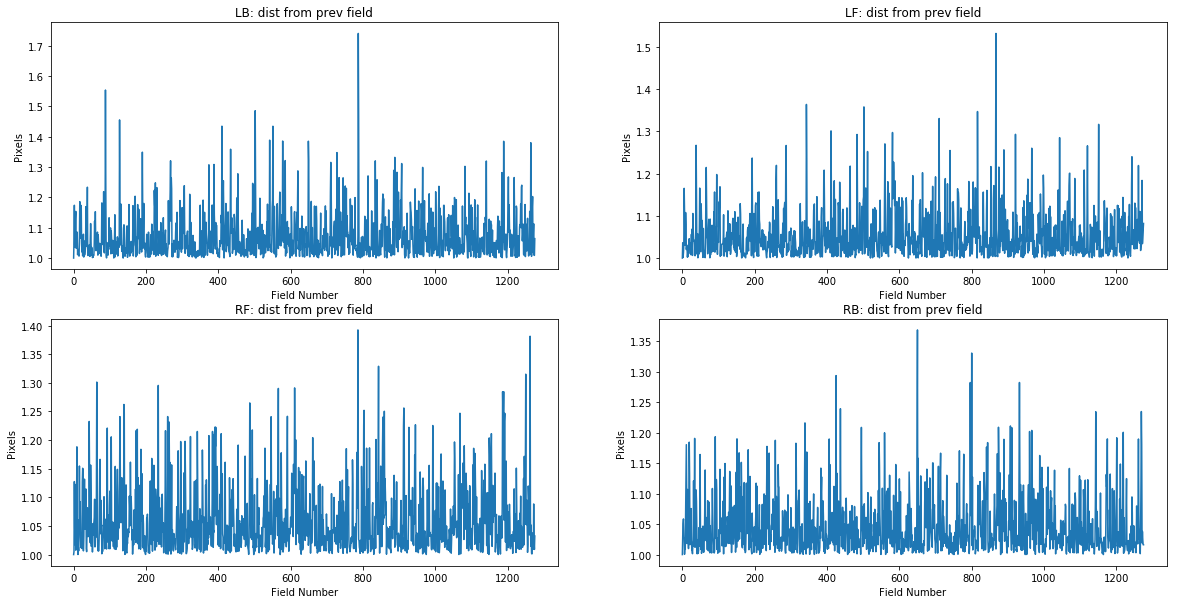

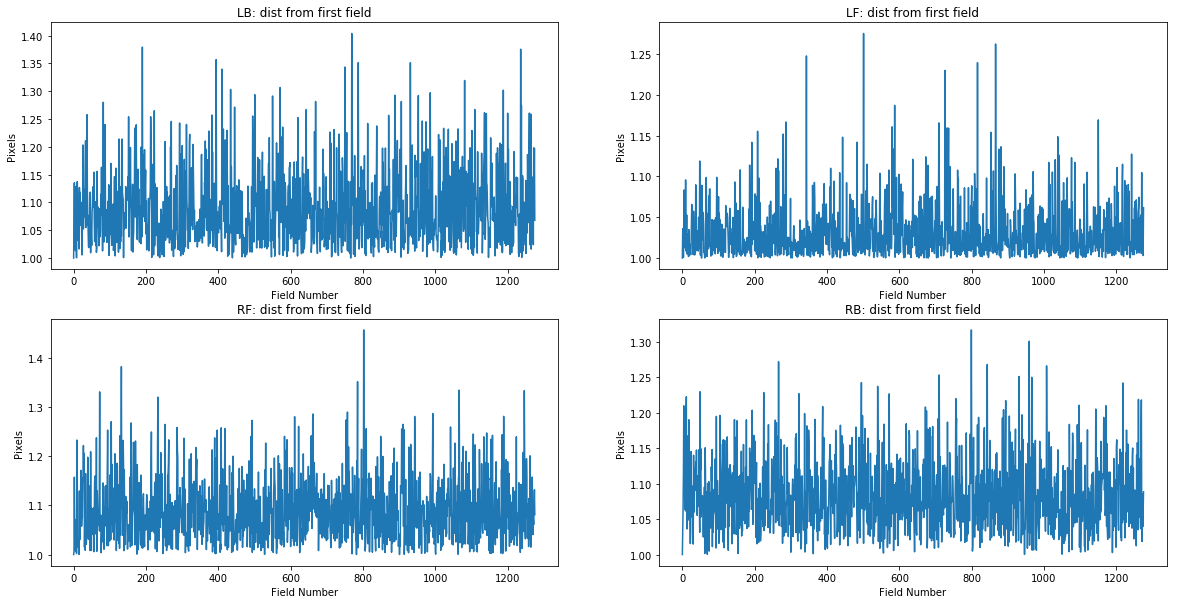

In [87]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

for loc, ax in zip(locs, axes.flat):
    ax.plot(norms_from_previous[loc])
    ax.set_title(f"{loc}: dist from prev field", fontsize=12)
    ax.set_xlabel('Field Number')
    ax.set_ylabel('Pixels')

fig, axes = plt.subplots(2, 2, figsize=(20, 10))

for loc, ax in zip(locs, axes.flat):
    ax.plot(norms_from_f1[loc])
    ax.set_title(f"{loc}: dist from first field", fontsize=12)
    ax.set_xlabel('Field Number')
    ax.set_ylabel('Pixels')

# ax[1].plot(norms_from_index1)
# ax[1].set_title("Norms from first field", fontsize=12)
# ax[1].set_xlabel('Field Number')
# ax[1].set_ylabel('Pixels')


In [69]:
for loc in locs:
    d = np.array(norms_from_previous[loc])
    print(f"Location {loc}:)